# English and French Dual Translation with RNN

In [1]:
import nltk
import re
import requests

import functools as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from typing import *

In [2]:
class Tokenizer:
    __slots__ = [
          'vocab_w'
        , 'vocab_i'
        , 'padder_w'
        , 'padder_i'
        , 'oov_w'
        , 'oov_i'
    ]

    def __init__(self, words: pd.Series):
        padder = '__PADDER__'
        oov = '__OOV__'
        w = pd.concat([words, pd.Series([padder, oov])])

        self.vocab_w = {x: i for i, x in enumerate(set(w))}
        self.vocab_i = {i: x for i, x in enumerate(set(w))}

        self.padder_w = padder
        self.padder_i = self.vocab_w[padder]

        self.oov_w = oov
        self.oov_i = self.vocab_w[oov]

In [3]:
def build_data(df: pd.DataFrame, col: str, tokens: Tokenizer) -> np.array:
    '''
    Build a tokenized 2D array from the specified column of words
    
    df: pandas dataframe containing a sentence column and word count column
    col: name of the column to extract the words from
    tokens: tokenizer used to transform the text into integers
    '''
    count = f'{col}Count'

    matrix = np.zeros((df.shape[0], df[count].max()))

    for i1, row in df.reset_index().iterrows():
        for i2 in range(matrix.shape[1]):
            if i2 < row[count]:
                if tokens.vocab_w.get(row[col][i2]):
                    matrix[i1, i2] = tokens.vocab_w[row[col][i2]]
                else:
                    matrix[i1, i2] = tokens.oov_i
            else:
                matrix[i1, i2] = tokens.padder_i
                
    return matrix


def build_dataframe(en_url: str, fr_url: str) -> pd.DataFrame:
    '''
    Build a dataframe containing english and french translations of text and a word count for each translation
    
    en_url: url to the raw english text data
    fr_url: url to the raw french text data
    '''
    return pd.DataFrame({
          'En': get_data(en_url)
        , 'Fr': get_data(fr_url)
    }).assign(
          EnCount = lambda df: df.En.map(len)
        , FrCount = lambda df: df.Fr.map(len)
    ).query('En != Fr')


def build_model(x_shape: int, y_shape: int, dim_input: int, dim_output: int, dim_embedding: int = 64) -> tf.keras.Model:
    '''
    Build a tensorflow RNN with encoding and decoding for text translation
    
    x_shape: the padded length of the input text
    y_shape: the padded length of the output text
    dim_input: size of the vocabulary of the input text
    dim_output: size of the vocabulary of the output text
    dim_embedding: size of the context embedding (default: 64)
    '''
    return tf.keras.Sequential([
        # Embedding
          tf.keras.layers.Embedding(
              input_dim = dim_input
            , output_dim = dim_embedding
            , input_length = x_shape
        )

        # Encoder
        , tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
              units = dim_embedding
        ))
        , tf.keras.layers.RepeatVector(y_shape)

        # Decoder
        , tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
              units = dim_embedding
            , return_sequences = True
        ))
        , tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(
              units = 128
            , activation = 'relu'
        ))
        , tf.keras.layers.Dropout(0.2)

        # Output
        , tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(
              units = dim_output
            , activation = 'softmax'
        ))
    ])


def build_string(array: np.array, tokens: Tokenizer) -> str:
    '''
    Build a printable string of a tokenized output
    
    array: output contianing tokenized words
    tokens: tokenizer used to convert the output to text
    '''
    unpad = np.delete(array, np.argwhere(array == tokens.padder_i))
    words = [tokens.vocab_i[y] for y in unpad]
    return str.join(' ', words)


def clean_text(text: str) -> str:
    '''
    Cleans raw text data for use in text translation
    
    text: text string to be cleaned
    '''
    patterns = [
        # space out punctuation
        (r'([a-zA-Z0-9])([,;.!?]+)', r'\1 \2')
    ]

    return F.reduce(
          lambda text, pattern: re.sub(pattern[0], pattern[1], text)
        , patterns
        , text.lower()
    )


def get_data(url: str) -> List[str]:
    '''
    Retrieves, cleans, and formats raw text data for use in text translation
    
    url: url to retrieve the data
    '''
    for sentence in requests.get(url).text.split('\n')[:-1]:
        yield clean_text(sentence).split()


def get_similarity(s1: np.array, s2: np.array) -> float:
    '''
    Get the cosine similarity between two strings of text
    '''
    ws = list(set(np.concatenate([s1, s2])))

    v1 = np.zeros(len(ws))
    v2 = np.zeros(len(ws))

    for w in s1:
        v1[ws.index(w)] += 1

    for w in s2:
        v2[ws.index(w)] += 1

    return 1 - nltk.cluster.util.cosine_distance(v1, v2)


def show_prediction(model: tf.keras.Model, x_test: np.array, y_tokens: Tokenizer, y_test: None) -> np.array:
    '''
    Prints the translation of a given text by the given model
    
    model: tensorflow model to use for translation
    x_test: text to translate
    y_tokens: tokenizer used to convert the translated output to text
    y_test: the actual translation, if given, to be used for comparison 
        and to calculate similarity between the true translation and the model's translation
    '''
    y_pred = np.argmax(model.predict(x_test)[0], axis = 1)

    print_pred = build_string(y_pred, y_tokens)
    print(f'Pred: {print_pred}')
    
    if y_test is not None:
        print_test = build_string(y_test, y_tokens)
        similarity = get_similarity(y_pred, y_test) * 100
        print(f'Test: {print_test}')
        print(f'{str.format("{:.4f}", similarity).rstrip("0")}% ** Similarity includes padding. Short sentences may have slightly inflated scores. **')

    return y_pred


def plot_fit(fit):
    '''
    Plots a tensorflow fit's history
    '''
    pd.DataFrame(fit.history).plot(figsize = (8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

### Get the training data contianing English and French translations of text

### It is worth noting that this corpus has a relatively small vocabulary, which will make training easier for the sake of learning machine translation but this will also lead to issues when trying it on new data.

In [4]:
df = build_dataframe(
      en_url = 'https://raw.githubusercontent.com/tommytracey/AIND-Capstone/master/data/small_vocab_en'
    , fr_url = 'https://raw.githubusercontent.com/tommytracey/AIND-Capstone/master/data/small_vocab_fr'
)

df

,En,Fr,EnCount,FrCount
0,"[new, jersey, is, sometimes, quiet, during, au...","[new, jersey, est, parfois, calme, pendant, l'...",15,16
1,"[the, united, states, is, usually, chilly, dur...","[les, états-unis, est, généralement, froid, en...",17,15
2,"[california, is, usually, quiet, during, march...","[california, est, généralement, calme, en, mar...",15,15
3,"[the, united, states, is, sometimes, mild, dur...","[les, états-unis, est, parfois, légère, en, ju...",16,15
4,"[your, least, liked, fruit, is, the, grape, ,,...","[votre, moins, aimé, fruit, est, le, raisin, ,...",16,16
...,...,...,...,...
137855,"[france, is, never, busy, during, march, ,, an...","[la, france, est, jamais, occupée, en, mars, ,...",15,16
137856,"[india, is, sometimes, beautiful, during, spri...","[l', inde, est, parfois, belle, au, printemps,...",14,15
137857,"[india, is, never, wet, during, summer, ,, but...","[l', inde, est, jamais, mouillé, pendant, l', ...",15,17
137858,"[france, is, never, chilly, during, january, ,...","[la, france, est, jamais, froid, en, janvier, ...",15,16


### Create tokens for both languages

In [5]:
en_tokens = Tokenizer(df.En.explode())
fr_tokens = Tokenizer(df.Fr.explode())

len(en_tokens.vocab_w), len(fr_tokens.vocab_w)

(204, 356)

### Use tokens to create TensorFlow friendly arrays

In [6]:
en = build_data(df, 'En', en_tokens)
fr = build_data(df, 'Fr', fr_tokens)

en.shape, fr.shape

((137860, 17), (137860, 23))

In [7]:
en[0], fr[0]

(array([152., 122., 156., 125.,  51., 140., 126., 170.,  89.,  50., 156.,
        161.,  78., 136.,  94., 112., 112.]),
 array([145., 232.,  35.,  89., 293.,  95., 335., 284., 334., 343.,  12.,
         35., 240., 113., 126., 217., 226., 226., 226., 226., 226., 226.,
        226.]))

In [8]:
np.random.seed(11)
tf.random.set_seed(11)

### Build a model for English to French Translation

In [9]:
model_en_fr = build_model(
      x_shape = en.shape[1]
    , y_shape = fr.shape[1]
    , dim_input = len(en_tokens.vocab_w)
    , dim_output = len(fr_tokens.vocab_w)
    , dim_embedding = 64
)

model_en_fr.compile(
      loss = 'sparse_categorical_crossentropy'
    , optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
    , metrics = ['accuracy']
)

model_en_fr.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 64)            13056     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 repeat_vector (RepeatVector  (None, 23, 128)          0         
 )                                                               
                                                                 
 bidirectional_1 (Bidirectio  (None, 23, 128)          98816     
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, 23, 128)          16512     
 ibuted)                                                

### Build a second model for French to English translation

In [10]:
model_fr_en = build_model(
      x_shape = fr.shape[1]
    , y_shape = en.shape[1]
    , dim_input = len(fr_tokens.vocab_w)
    , dim_output = len(en_tokens.vocab_w)
    , dim_embedding = 64
)

model_fr_en.compile(
      loss = 'sparse_categorical_crossentropy'
    , optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)
    , metrics = ['accuracy']
)

model_fr_en.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 64)            22784     
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 repeat_vector_1 (RepeatVect  (None, 17, 128)          0         
 or)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 17, 128)          98816     
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 17, 128)          16512     
 tributed)                                            

In [11]:
callbacks = [
      tf.keras.callbacks.EarlyStopping(
          monitor = 'val_accuracy'
        , patience = 3
    )
    , tf.keras.callbacks.ReduceLROnPlateau(
          monitor = 'val_accuracy'
        , factor = 0.7
        , patience = 2
        , min_lr = 0.001
    )
]

### Train both models

Epoch 1/25
221/221 [==============================] - 19s 38ms/step - loss: 1.9909 - accuracy: 0.5233 - val_loss: 1.1918 - val_accuracy: 0.6601 - lr: 0.0100
Epoch 2/25
221/221 [==============================] - 6s 25ms/step - loss: 1.0342 - accuracy: 0.6982 - val_loss: 0.7640 - val_accuracy: 0.7704 - lr: 0.0100
Epoch 3/25
221/221 [==============================] - 4s 19ms/step - loss: 0.6903 - accuracy: 0.7922 - val_loss: 0.5048 - val_accuracy: 0.8487 - lr: 0.0100
Epoch 4/25
221/221 [==============================] - 4s 20ms/step - loss: 0.4685 - accuracy: 0.8589 - val_loss: 0.3384 - val_accuracy: 0.9018 - lr: 0.0100
Epoch 5/25
221/221 [==============================] - 4s 20ms/step - loss: 0.3461 - accuracy: 0.8988 - val_loss: 0.2579 - val_accuracy: 0.9274 - lr: 0.0100
Epoch 6/25
221/221 [==============================] - 4s 19ms/step - loss: 0.2654 - accuracy: 0.9241 - val_loss: 0.2005 - val_accuracy: 0.9448 - lr: 0.0100
Epoch 7/25
221/221 [==============================] - 5s 22ms/s

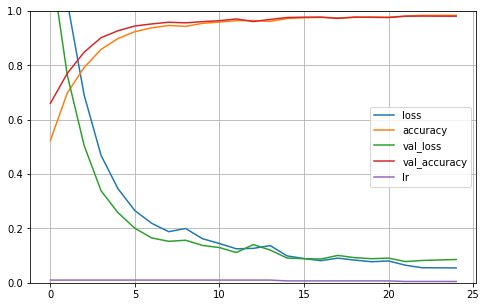

In [12]:
fit_en_fr = model_en_fr.fit(
      x = en
    , y = fr
    , validation_split = 0.2
    , callbacks = callbacks
    , batch_size = 500
    , epochs = 25
)
plot_fit(fit_en_fr)

Epoch 1/25
221/221 [==============================] - 11s 23ms/step - loss: 1.8692 - accuracy: 0.5146 - val_loss: 1.5679 - val_accuracy: 0.5443 - lr: 0.0100
Epoch 2/25
221/221 [==============================] - 4s 16ms/step - loss: 0.9299 - accuracy: 0.6827 - val_loss: 0.6997 - val_accuracy: 0.7388 - lr: 0.0100
Epoch 3/25
221/221 [==============================] - 4s 16ms/step - loss: 0.6665 - accuracy: 0.7506 - val_loss: 0.5627 - val_accuracy: 0.7838 - lr: 0.0100
Epoch 4/25
221/221 [==============================] - 4s 16ms/step - loss: 0.6211 - accuracy: 0.7700 - val_loss: 0.5213 - val_accuracy: 0.7952 - lr: 0.0100
Epoch 5/25
221/221 [==============================] - 4s 17ms/step - loss: 0.5026 - accuracy: 0.7994 - val_loss: 0.4374 - val_accuracy: 0.8136 - lr: 0.0100
Epoch 6/25
221/221 [==============================] - 4s 17ms/step - loss: 0.4348 - accuracy: 0.8221 - val_loss: 0.3666 - val_accuracy: 0.8441 - lr: 0.0100
Epoch 7/25
221/221 [==============================] - 4s 17ms/s

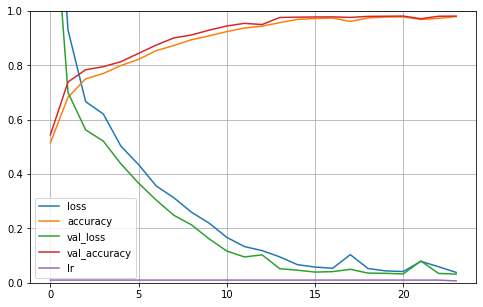

In [13]:
fit_fr_en = model_fr_en.fit(
      x = fr
    , y = en
    , validation_split = 0.2
    , callbacks = callbacks
    , batch_size = 500
    , epochs = 25
)
plot_fit(fit_fr_en)

### Both of our models achieved high accuray without overfitting on the training data

### We can see how our translations compare to the training data. First We will do one of each translation on the same row.

In [14]:
i_test = 57676 # np.random.randint(0, df.shape[0])

In [15]:
test1_en = show_prediction(
      model = model_fr_en
    , x_test = fr[i_test: i_test + 1]
    , y_tokens = en_tokens
    , y_test = en[i_test]
)

1/1 [==============================] - 1s 1s/step
Pred: china is sometimes hot during november , but it is snowy in december .
Test: china is sometimes hot during november , but it is snowy in december .
100.% ** Similarity includes padding. Short sentences may have slightly inflated scores. **


In [16]:
test1_fr = show_prediction(
      model = model_en_fr
    , x_test = en[i_test: i_test + 1]
    , y_tokens = fr_tokens
    , y_test = fr[i_test]
)

1/1 [==============================] - 1s 1s/step
Pred: la chine est parfois chaud au mois de novembre , mais il est neigeux en décembre .
Test: la chine est parfois chaud au mois de novembre , mais il est neigeux en décembre .
100.% ** Similarity includes padding. Short sentences may have slightly inflated scores. **


### Then we can see how the translations we generated translate again. Essentially, will we get a "telephone game" effect where errors cascade into more and more errors.

### In this case we didn't, however in earlier attempts of training using this row as an example, the English translation of "hot" would often be translated as "warm", which would cause the second iteration back to French to leave out the word "la", exemplifying the telephone effect.

In [17]:
test2_en = show_prediction(
      model = model_fr_en
    , x_test = np.array([test1_fr])
    , y_tokens = en_tokens
    , y_test = en[i_test]
)

1/1 [==============================] - 1s 1s/step
Pred: china is sometimes hot during november , but it is snowy in december .
Test: china is sometimes hot during november , but it is snowy in december .
100.% ** Similarity includes padding. Short sentences may have slightly inflated scores. **


In [18]:
test2_fr = show_prediction(
      model = model_en_fr
    , x_test = np.array([test1_en])
    , y_tokens = fr_tokens
    , y_test = fr[i_test]
)

1/1 [==============================] - 1s 1s/step
Pred: la chine est parfois chaud au mois de novembre , mais il est neigeux en décembre .
Test: la chine est parfois chaud au mois de novembre , mais il est neigeux en décembre .
100.% ** Similarity includes padding. Short sentences may have slightly inflated scores. **


### Get test data

In [19]:
df_test = build_dataframe(
      en_url = 'https://raw.githubusercontent.com/rbawden/DiaBLa-dataset/master/DiaBLa-corpus/raw-corpus/diabla.en2fr.orig'
    , fr_url = 'https://raw.githubusercontent.com/rbawden/DiaBLa-dataset/master/DiaBLa-corpus/raw-corpus/diabla.fr2en.orig'
)

df_test

,En,Fr,EnCount,FrCount
1,"[as, you, say, .]","[comme, vous, dites, .]",4,4
2,"[i, ve, got, so, much, to, do, today, ,, you, ...","[j'ai, tant, à, faire, aujourd'hui, ,, tu, sai...",18,19
3,"[let's, see, if, anything, happens, quickly, .]","[attendons, de, voir, si, quelque, chose, se, ...",7,10
4,"[this, lift, is, often, breaking, ,]","[cet, ascenseur, se, brise, souvent, ,]",6,6
5,"[i, wish, i, had, climbed, the, stairs]","[j'aimerais, avoir, grimpé, l'escalier, .]",7,5
...,...,...,...,...
5743,"[he, is, probably, about, to, be, laid, off, b...","[il, est, probablement, sur, le, point, d'être...",12,15
5744,"[for, the, plane, moving, like, that, ?]","[pour, l'avion, bouge, comme, ça, ?]",7,6
5745,"[it's, way, too, heavy, in, there, ,, and, the...","[ça, tangue, beaucoup, trop, là,, et, les, hot...",15,14
5746,"[it's, obvious, they're, trying, to, keep, the...","[ça, se, voit, qu'elles, essaient, de, garder,...",9,9


In [20]:
en_test = build_data(df_test, 'En', en_tokens)
fr_test = build_data(df_test, 'Fr', fr_tokens)

en_test.shape, fr_test.shape

((5690, 46), (5690, 73))

### Using our models to translate the new text and using cosine similarity as an accuray metric we see that we have relatively promising results. However looking further into our results will give us a better idea of the performance.

In [22]:
pred_en_fr = model_en_fr.predict(en_test, verbose = False)
similarity_en_fr = 0

for i in range(en_test.shape[0]):
    fr_pred = np.argmax(pred_en_fr[i], axis = 1)
    similarity_en_fr += get_similarity(fr_pred, fr_test[i])
similarity_en_fr = similarity_en_fr / en_test.shape[0]

similarity_en_fr

0.9735160858101196

In [23]:
pred_fr_en = model_fr_en.predict(fr_test, verbose = False)
similarity_fr_en = 0

for i in range(fr_test.shape[0]):
    en_pred = np.argmax(pred_fr_en[i], axis = 1)
    similarity_fr_en += get_similarity(en_pred, en_test[i])
similarity_fr_en = similarity_fr_en / fr_test.shape[0]

similarity_fr_en

0.9296233995398684

### If we look at individual translations, we can see that the generated text is often nonsensical, but also that many of the words in our test data are outside of the vocabulary of our models. This comes back to the limited vocabulary of our training data. 

### In order to get better results with more real word data we would want to expand the scope of our training data's vocabulary.

In [25]:
i_test = np.random.randint(0, df_test.shape[0])

In [26]:
test3_en = show_prediction(
      model = model_fr_en
    , x_test = fr_test[i_test: i_test + 1]
    , y_tokens = en_tokens
    , y_test = en_test[i_test]
)

1/1 [==============================] - 0s 64ms/step
Pred: i we going to the football field ?
Test: i like it when __OOV__ __OOV__ __OOV__ the __OOV__ . __OOV__ you do that ?
94.7162% ** Similarity includes padding. Short sentences may have slightly inflated scores. **


In [27]:
test3_fr = show_prediction(
      model = model_en_fr
    , x_test = en_test[i_test: i_test + 1]
    , y_tokens = fr_tokens
    , y_test = fr_test[i_test]
)

1/1 [==============================] - 0s 26ms/step
Pred: j'aime le pamplemousse et les citrons .
Test: j'aime quand il __OOV__ a du __OOV__ __OOV__ du __OOV__ .
98.5392% ** Similarity includes padding. Short sentences may have slightly inflated scores. **


In [28]:
test4_en = show_prediction(
      model = model_fr_en
    , x_test = np.array([test3_fr])
    , y_tokens = en_tokens
    , y_test = en_test[i_test]
)

1/1 [==============================] - 0s 21ms/step
Pred: i like grapefruit and lemons .
Test: i like it when __OOV__ __OOV__ __OOV__ the __OOV__ . __OOV__ you do that ?
96.7224% ** Similarity includes padding. Short sentences may have slightly inflated scores. **


In [29]:
test4_fr = show_prediction(
      model = model_en_fr
    , x_test = np.array([test3_en])
    , y_tokens = fr_tokens
    , y_test = fr_test[i_test]
)

1/1 [==============================] - 0s 18ms/step
Pred: elle est le le __OOV__ __OOV__ de
Test: j'aime quand il __OOV__ a du __OOV__ __OOV__ du __OOV__ .
98.3887% ** Similarity includes padding. Short sentences may have slightly inflated scores. **
